# 0. Setting Up The Env

## 0.1 Import Packages

In [118]:
from pathlib import Path

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 0.2 Utilities

In [121]:
class KMeansModelBuilder:
    def __init__(self, data: pd.DataFrame, random_state: int = 99):
        """
        Initialize with a pandas DataFrame.
        Args:
            data (pd.DataFrame): Processed input data
            random_state (int): Random seed for reproducibility
        """
        self.data = data
        self.random_state = random_state
        self.scaled_data = None
        self.kmeans = None
        self.optimal_k = None
        self.wcss_scores = []
        self.silhouette_scores = []
        self.wcss_drop = []


    def scale_data(self):
        """Standardize data using StandardScaler."""
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data)
        print("Data successfully scaled using StandardScaler.")

    def evaluate_k_values(self, max_k = 10):
        """
        Evaluate different K values to find the optimal one using
        WCSS (Elbow method) and Silhouette Score.
        Also computes WCSS drop (ΔWCSS) between consecutive K.
        
        Args:
            max_k (int): Maximum number of clusters to evaluate (default = 10)
        """
        k_range = range(2, max_k+1)
        if self.scaled_data is None:
            raise ValueError("Data must be scaled before evaluation. Call scale_data().")

        self.wcss_scores = []
        self.silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(self.scaled_data)
            wcss = kmeans.inertia_
            sil_score = silhouette_score(self.scaled_data, kmeans.labels_)

            self.wcss_scores.append(wcss)
            self.silhouette_scores.append(sil_score)

            print(f"K={k}: WCSS={wcss:.2f}, Silhouette Score={sil_score:.4f}")

        # Compute WCSS drop (difference between consecutive WCSS values)
        self.wcss_drop = [self.wcss_scores[i-1] - self.wcss_scores[i] for i in range(1, len(self.wcss_scores))]

        # Determine best K based on the maximum silhouette score
        optimal_k = k_range[np.argmax(self.silhouette_scores)]
        print(f"\n Optimal K based on silhouette score: {optimal_k}")

        # Plot results
        self._plot_metrics(k_range)

    def _plot_metrics(self, k_range):
        """Private method to plot Elbow Curve and Silhouette Scores."""
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot Elbow Curve
        ax[0].plot(k_range, self.wcss_scores, marker='o', color='blue')
        ax[0].set_title("Elbow Method (WCSS)")
        ax[0].set_xlabel("Number of Clusters (K)")
        ax[0].set_ylabel("WCSS")

        # Plot WCSS Drop (ΔWCSS)
        drop_k = list(k_range)[1:]  # since drop starts from K=3 (difference from previous)
        ax[1].plot(drop_k, self.wcss_drop, marker='o', color='orange')
        ax[1].set_title("WCSS Drop Between Consecutive K")
        ax[1].set_xlabel("Number of Clusters (K)")
        ax[1].set_ylabel("ΔWCSS (Previous - Current)")


        # Plot Silhouette Scores
        ax[2].plot(k_range, self.silhouette_scores, marker='o', color='red')
        ax[2].set_title("Silhouette Scores for K values")
        ax[2].set_xlabel("Number of Clusters (K)")
        ax[2].set_ylabel("Silhouette Score")

        plt.tight_layout()
        plt.show()


    def plot_elbow_silhouette_tradeoff(self, max_k):
        """
        Plot a combined Elbow + Silhouette chart to visualize the trade-off.
        WCSS is scaled (min-max normalization) for better comparison.
        """
        k_range = range(2, max_k + 1)
        if not self.wcss_scores or not self.silhouette_scores:
            raise ValueError("Run evaluate_k_values() first to compute WCSS and silhouette scores.")

        # Normalize WCSS for comparison
        wcss_scaled = (np.array(self.wcss_scores) - np.min(self.wcss_scores)) / (
            np.max(self.wcss_scores) - np.min(self.wcss_scores)
        )

        fig, ax1 = plt.subplots(figsize=(18, 5))

        # Plot WCSS (inverted because lower is better)
        ax1.plot(k_range, 1 - wcss_scaled, color='blue', marker='o', label='Normalized WCSS')
        ax1.set_xlabel('Number of Clusters (K)')
        ax1.set_ylabel('Normalized WCSS', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot Silhouette Score on secondary axis
        ax2 = ax1.twinx()
        ax2.plot(k_range, self.silhouette_scores, color='red', marker='o', label='Silhouette Score')
        ax2.set_ylabel('Silhouette Score', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

        plt.title("Elbow + Silhouette Trade-off Chart")
        plt.tight_layout()
        plt.show()


    def build_final_model(self, k):
        """Fit KMeans using the optimal number of clusters."""
        self.optimal_k = k

        self.kmeans = KMeans(
            n_clusters=self.optimal_k, 
            random_state=self.random_state,
            n_init=10
        )
        self.kmeans.fit(self.scaled_data)
        labels = self.kmeans.labels_

        sil_score = silhouette_score(self.scaled_data, labels)
        print(f"Final KMeans model built with K={self.optimal_k}")
        print(f"Final Silhouette Score: {sil_score:.4f}")

        return labels

## 0.3 Constants

In [122]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [123]:
capped_file_path = f"{project_root}/data/processed/capped.csv"
target_file_path = f"{project_root}/data/processed/target.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target.csv')

# 1. The Data

In [124]:
data_X_df = pd.read_csv(capped_file_path)
print(data_X_df.shape)
data_X_df.head()

(4521, 33)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,30,0,1787.0,0,0,19,79,1,-1,0,...,1,0,1,0,0,1,0,0,0,1
1,33,0,4789.0,1,1,11,220,1,339,4,...,1,0,0,1,0,1,0,1,0,0
2,35,0,1350.0,1,0,16,185,1,330,1,...,0,1,0,0,1,1,0,1,0,0
3,30,0,1476.0,1,1,3,199,4,-1,0,...,1,0,0,0,1,0,1,0,0,1
4,59,0,0.0,1,0,5,226,1,-1,0,...,1,0,0,1,0,0,1,0,0,1


In [125]:
data_X_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'sin_month', 'cos_month', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype='object')

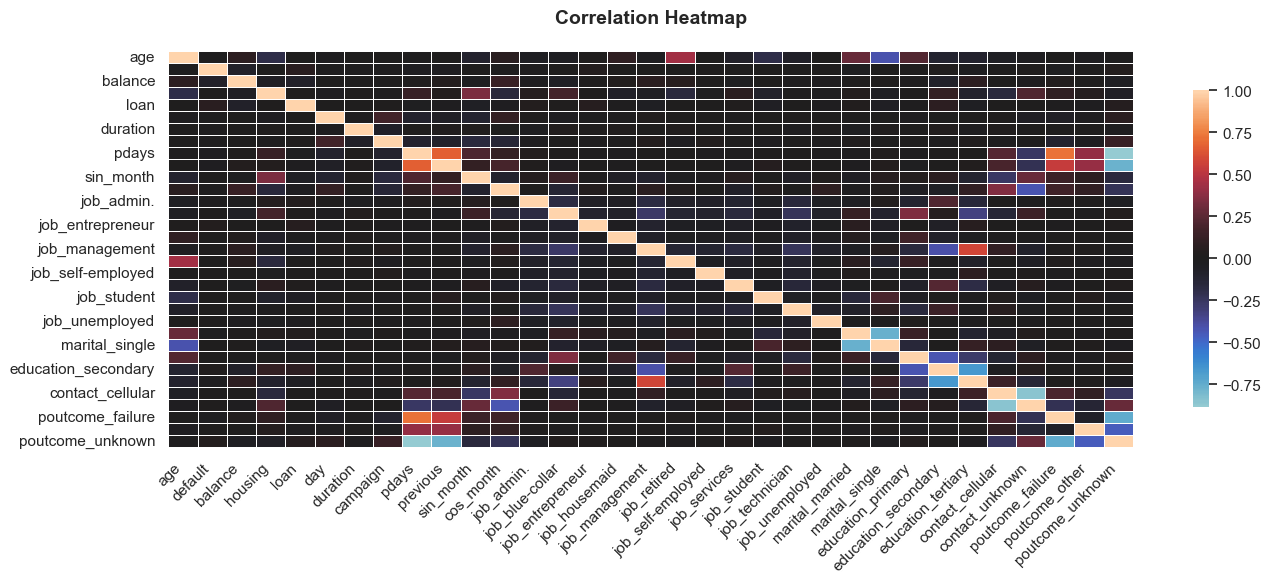

In [126]:
plt.figure(figsize=(14, 6))
corr = data_X_df.corr(numeric_only=True)

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # add grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

*To be Added*
* Corr With Target Variable
* Filter Based On That


# 2. Model Builder

In [127]:
model_builder = KMeansModelBuilder(data_X_df)
model_builder.scale_data()


Data successfully scaled using StandardScaler.


K=2: WCSS=133750.41, Silhouette Score=0.1890
K=3: WCSS=124706.72, Silhouette Score=0.0919
K=4: WCSS=119135.69, Silhouette Score=0.0912
K=5: WCSS=114197.40, Silhouette Score=0.1035
K=6: WCSS=109894.66, Silhouette Score=0.1074
K=7: WCSS=106678.40, Silhouette Score=0.1132
K=8: WCSS=102699.65, Silhouette Score=0.1029
K=9: WCSS=98558.28, Silhouette Score=0.1321
K=10: WCSS=95391.19, Silhouette Score=0.1536

 Optimal K based on silhouette score: 2


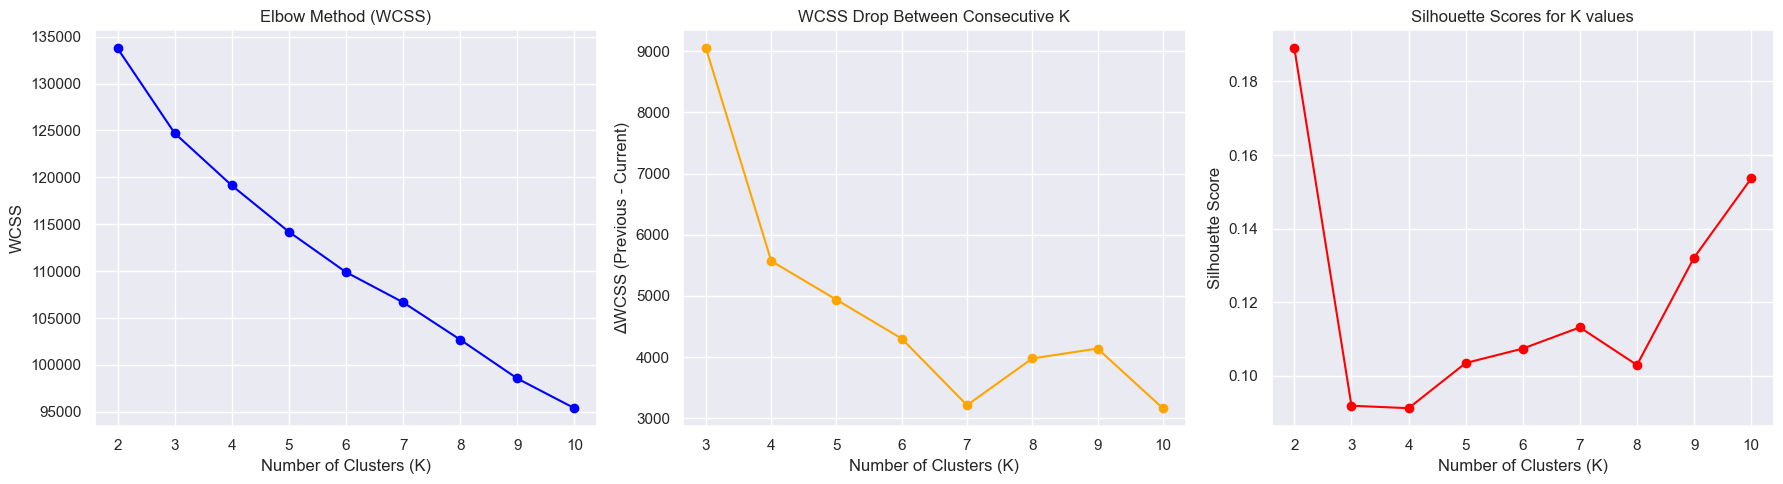

In [128]:
model_builder.evaluate_k_values(10)

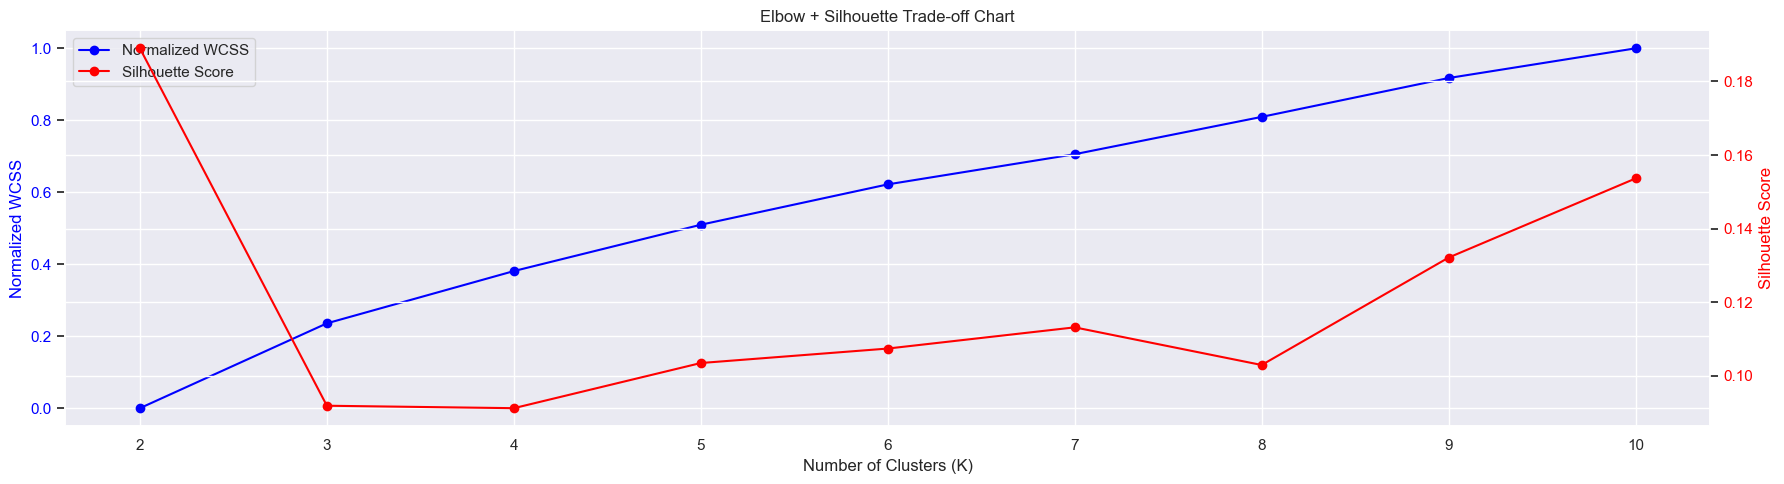

In [131]:
model_builder.plot_elbow_silhouette_tradeoff(10)

In [132]:
labels = model_builder.build_final_model(3)


Final KMeans model built with K=3
Final Silhouette Score: 0.0919


# END